In [1]:
import SimpleITK as sitk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
from scipy import signal
from numpy import *
from pylab import *
import cv2
import random

from random import randrange
from numpy import linalg 
from scipy import signal
from pylab import *
from PIL import Image
from skimage.transform import warp

## full matrix
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
## imshow problem
#import tkinter
#import matplotlib
#matplotlib.use('TkAgg')

directory='/home/mahdi/python codes/final version/SP_S05_D1_RND.nii'
I = sitk.ReadImage(directory)
I = sitk.GetArrayFromImage(I)



## t.shape[0]   ## for volume
def mask(I,volume, layer):
        
        if volume<10:
            name=str(0)+str(0)+str(volume)
        if 9<volume<100:
            name=str(0)+str(volume)
        if 99<volume<1000:
            name=str(volume)
            
        g=I[volume,layer,:,:]
        g=g.astype(np.float32)
        df = pd.read_csv('/home/mahdi/python codes/centerline_case2/centerline_volume'+name+'.csv', header=None)
        df.columns=['x','y','delete']
        df=df[['x','y']]
        c=df.loc[layer]
        x=int(c['x'])
        y=int(c['y'])
        f=g[y-15:y+15,x-15:x+15]
        return f

In [2]:
# function defines the gaussian function used for convolution which returns the 
def GaussianFunction(x, sigma):
    if sigma == 0:
        return 0
    else:
        g = (1/math.sqrt(2*math.pi*sigma*sigma))*math.exp(-x*x)/(2*sigma*sigma)
    return g

# function returns the gaussian kernel using the GaussianFunction of size 3x3
def GaussianMask(sigma):
    g = []
    for i in range(-2, 3):#creating a gaussian kernel of size 3x3
        g1 = GaussianFunction(i,sigma)
        g2 = GaussianFunction(i-0.5, sigma)
        g3 = GaussianFunction(i+0.5, sigma)
        gaussian = (g1+g2+g3)/3
        g.append(gaussian)
    return g

sigma = 1.5
G = [] # Gaussian Kernel
G = GaussianMask(sigma)

def DownSample(I): 
    Ix = Iy  = []
    I = np.array(I)
    S = np.shape(I)      #shape of the image
    for i in range(S[0]):
        Ix.extend([signal.convolve(I[i,:],G,'same')])#convolution of the I[i] with G
    Ix = np.array(np.matrix(Ix))
    Iy = Ix[::2, ::2]#selects the alternate column and row
    return Iy

def UpSample(I):
    I = np.array(I)
    S = np.shape(I)

    Ix = np.zeros((S[0], 2*S[1]))#inserting alternate rows of zeros
    Ix[:, ::2] = I
    S1 = np.shape(Ix)
    Iy = np.zeros((2*S1[0], S1[1]))#inserting alternate columns of zeros
    Iy[::2, :] = Ix
    Ig = cv2.GaussianBlur(Iy, (5,5), 1.5, 1.5)#instead of using the user-defined gaussian function, I am using the Gaussian Blur functtion for double the size of gaussian kernel size
    return Ig

def LucasKanade(I1, I2):
    I1 = np.array(I1)
    I2 = np.array(I2)
    S  = np.shape(I1)

    Ix = signal.convolve2d(I1,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2,[[-0.25,0.25],[-0.25,0.25]],'same')
    Iy = signal.convolve2d(I1,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2,[[-0.25,-0.25],[0.25,0.25]],'same')
    It = signal.convolve2d(I1,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2,[[-0.25,-0.25],[-0.25,-0.25]],'same')

    features = cv2.goodFeaturesToTrack(I1, 10000, 0.01, 10)
    features = np.int0(features)

    u = np.ones((S))
    v = np.ones((S))
    for l in features:
        j,i = l.ravel()
        #IX = ([Ix[i-1,j-1],Ix[i,j-1],Ix[i+1,j+1],Ix[i-1,j],Ix[i,j],Ix[i+1,j],Ix[i-1,j+1],Ix[i,j+1],Ix[i+1,j-1]])
        #IY = ([Iy[i-1,j-1],Iy[i,j-1],Iy[i+1,j+1],Iy[i-1,j],Iy[i,j],Iy[i+1,j],Iy[i-1,j+1],Iy[i,j+1],Iy[i+1,j-1]])
        #IT = ([It[i-1,j-1],It[i,j-1],It[i+1,j+1],It[i-1,j],It[i,j],It[i+1,j],It[i-1,j+1],It[i,j+1],It[i+1,j-1]])
        IX = ([Ix[i-1,j-1],Ix[i-1,j],Ix[i-1,j+1],Ix[i,j-1],Ix[i,j],Ix[i,j+1],Ix[i+1,j-1],Ix[i+1,j],Ix[i+1,j+1]])
        IY = ([Ix[i-1,j-1],Ix[i-1,j],Ix[i-1,j+1],Ix[i,j-1],Ix[i,j],Ix[i,j+1],Ix[i+1,j-1],Ix[i+1,j],Ix[i+1,j+1]])
        IT = ([Ix[i-1,j-1],Ix[i-1,j],Ix[i-1,j+1],Ix[i,j-1],Ix[i,j],Ix[i,j+1],Ix[i+1,j-1],Ix[i+1,j],Ix[i+1,j+1]])
        # Using the minimum least squares solution approach
        LK = (IX,IY)
        LK = matrix(LK)
        LK_T = array(matrix(LK))
        LK = array(np.matrix.transpose(LK))

        #Psedudo Inverse
        A1 = np.dot(LK_T,LK)
        A2 = np.linalg.pinv(A1)
        A3 = np.dot(A2,LK_T)
        (u[i,j],v[i,j]) = np.dot(A3,IT) # we have the vectors with minimized square error

  #  u = np.flipud(u)
   # v = np.flipud(v)
    return u,v

In [3]:
def LucasKanadeIterative(I1, I2, u1, v1):
   
    I1 = np.array(I1)
    I2 = np.array(I2)
    S = np.shape(I1)
    u1 = np.round(u1)
    v1 = np.round(v1)
    u = np.zeros(S)
    v = np.zeros(S)

    k=5
    for i in range(0,S[0]-(k-1)):
        for j in range(0,S[1]-(k-1)):

            I1new = I1[i:i+k,j:j+k]# picking kxk pixels at a time
            lr = (i)+v1[i,j]#Low Row Index
            hr = (i+k-1)+v1[i,j]#High Row Index
            lc = (j)+u1[i,j]#Low Column Index
            hc = (j+k-1)+u1[i,j]#High Column Index
            #window search and selecting the last window if it goes out of bounds
            if(lr < 0): 
                lr = 0
                hr = k-1
            if(lc < 0): 
                lc = 0
                hc = k-1
            if(hr > (len(I1[:,0]))-1): 
                lr = len(I1[:,0])-k
                hr = len(I1[:,0])-1                
            if(hc > (len(I1[0,:]))-1): 
                lc = len(I1[0,:])-k
                hc = len(I1[0,:])-1               
            if(np.isnan(lr)):
                lr = i
                hr = i+k-1
            if(np.isnan(lc)):
                lc = j
                hc = j+k-1
            #Selecting the same window for the second frame
            I2new = I2[int(lr):int((hr+1)),int(lc):int((hc+1))]
            # Now applying LK for each window of the 2 images
            Ix = signal.convolve2d(I1new,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,0.25],[-0.25,0.25]],'same')
            Iy = signal.convolve2d(I1new,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,-0.25],[0.25,0.25]],'same')
            It = signal.convolve2d(I1new,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,-0.25],[-0.25,-0.25]],'same')

            #IX =np.transpose(Ix[1:5,1:5])
            #IY = np.transpose(Iy[1:5,1:5])
            #IT = np.transpose(It[1:5,1:5])

            IX = Ix.ravel()
            IY = Iy.ravel()
            IT = It.ravel()

            LK = (IX,IY)
            LK = np.matrix(LK)
            LK_T = np.array(np.matrix(LK))
            LK = np.array(np.matrix.transpose(LK))

            A1 = np.dot(LK_T,LK)
            A2 = np.linalg.pinv(A1)
            A3 = np.dot(A2,LK_T)
            (u[i,j],v[i,j]) = np.dot(A3,IT)
    return u,v


In [4]:
def LK_Pyramid(Im1, Im2, iteration, level):
    I1 = np.array(Im1)
    I2 = np.array(Im2)
    S = np.shape(I1)

    pyramid1 = np.empty((S[0],S[1],level)) 
    pyramid2 = np.empty((S[0],S[1],level)) 
    pyramid1[:,:,0] = I1 #since the lowest level is the original imae
    pyramid2[:,:,0] = I2 #since the lowest level is the original image

    #creating the pyramid by downsampling the original image
    for i in range(1, level):
        I1 = DownSample(I1)
        I2 = DownSample(I2)
        pyramid1[0:np.shape(I1)[0], 0:np.shape(I1)[1], i] = I1
        pyramid2[0:np.shape(I2)[0], 0:np.shape(I2)[1], i] = I2

    level0_I1 = pyramid1[0:round(len(pyramid1[:,0])/4),0:round(len(pyramid1[0,:])/4),2]
    level0_I2 = pyramid2[0:round(len(pyramid2[:,0])/4),0:round(len(pyramid2[0,:])/4),2]
    (u,v) = LucasKanade(Im1, Im2)

    for i in range(0, iteration):
        (u,v) = LucasKanadeIterative(level0_I1, level0_I2, u, v)
    u_l0 = u
    v_l0 = v
    I_l0 = level0_I1
    u_l0[np.where(u_l0 == 0)] = nan
    v_l0[np.where(v_l0 == 0)] = nan

    #for level 1
    k = 1
    u1 = UpSample(u)
    v1 = UpSample(v)
    I1new = pyramid1[0:int(len(pyramid1[:,0])/(2**(level-k-1))),0:int(len(pyramid1[0,:])/(2**(level-k-1))),level-k-1]
    I2new = pyramid2[0:int(len(pyramid2[:,0])/(2**(level-k-1))),0:int(len(pyramid2[0,:])/(2**(level-k-1))),level-k-1]
    (u,v) = LucasKanadeIterative(I1new, I2new, u1, v1)

    u_l1 = u
    v_l1 = v
    I_l1 = I1new
    u_l1[np.where(u_l1 == 0)] = nan
    v_l1[np.where(v_l1 == 0)] = nan

    k = 2
    u1 = UpSample(u)
    v1 = UpSample(v)
    I1new = pyramid1[0:int(len(pyramid1[:,0])/(2**(level-k-1))),0:int(len(pyramid1[0,:])/(2**(level-k-1))),level-k-1]
    I2new = pyramid2[0:int(len(pyramid2[:,0])/(2**(level-k-1))),0:int(len(pyramid2[0,:])/(2**(level-k-1))),level-k-1]
    (u,v) = LucasKanadeIterative(I1new, I2new, u1, v1)

    u_l2 = u
    v_l2 = v
    I_l2 = I1new
    
    u_l2[np.where(u_l2 == 0)] = nan
    v_l2[np.where(v_l2 == 0)] = nan

    

    colours = "bgrcmykw"
    colour_index = random.randrange(0,8)
    c=colours[colour_index]

    plt.figure()
    plt.imshow(I_l0,cmap = cm.gray)
    plt.title('Level 0 - Base level')
    quiver(u_l0,v_l0,color = c)

    c=colours[colour_index]
    plt.figure()
    plt.imshow(I_l1,cmap = cm.gray)
    plt.title('Level 1')
    quiver(u_l1,v_l1,color = c)	
    
    c=colours[colour_index]
    plt.figure()
    plt.imshow(I_l2,cmap = cm.gray)
    plt.title('Level 2')
    plt.quiver(u_l2,v_l2,color = c)
    np.array(u_l2)
    
   
    
    


    nr, nc = Im1.shape
    
    row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                         indexing='ij')
    im1_warp = warp(I2new, np.array([row_coords + u_l2, col_coords + v_l2]),
                       order=1)   
   

    # build an RGB image with the unregistered sequence
    
    plt.figure()
    plt.imshow(im1_warp,cmap = cm.gray)
    plt.title('register')
    plt.figure()
    plt.imshow(Im1,cmap = cm.gray)
    plt.title('refrence image')
    plt.figure()
    plt.imshow(Im2,cmap = cm.gray)
    plt.title('second image')
    plt.show()


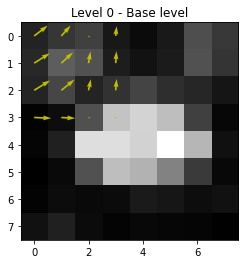

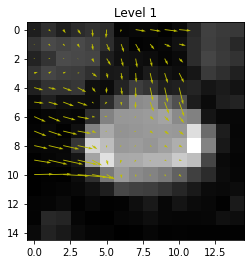

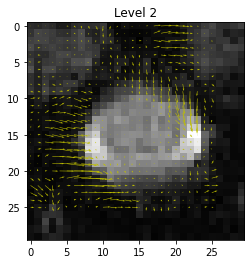

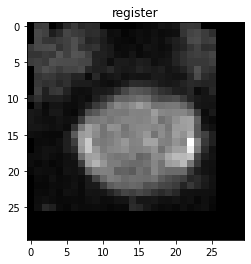

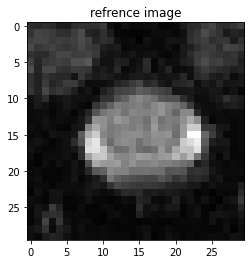

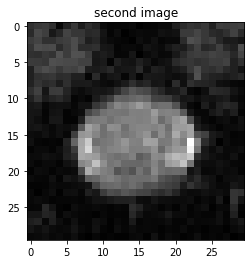

In [5]:
import random
%matplotlib inline

LK_Pyramid(mask(I,0,5), mask(I,1,5), 3, 3)